In [1]:
# load autoreload extension and instnatiate with 2 secs
# matplotlib inline

# #export and import exp.nb_02 * and import torch nn functional as F

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
# load x,y trains and x,y valid
# set n,m,c,nh as 50
# define a model class with a layer for [lin,relu,lin]
# get preds for x_train

In [5]:
x_train, y_train, x_valid, y_valid = get_data()
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [6]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [7]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers: x = l(x)            
        return x                    

In [8]:
model = Model(m, nh, 10)

In [9]:
pred = model(x_train)

In [10]:
# define log_softmax(x)
# log_softmax pred
# define nll(inp, targ) negative log likelyhood

In [11]:
def log_softmax(x):
    return (x.exp() / x.exp().sum(dim=1, keepdim=True)).log()

In [12]:
log_softmax(pred)[:2]

tensor([[-2.2314, -2.2209, -2.3749, -2.3563, -2.1197, -2.4826, -2.3490, -2.3665,
         -2.3805, -2.1986],
        [-2.3357, -2.2648, -2.2910, -2.3196, -2.1715, -2.4790, -2.3701, -2.3461,
         -2.3947, -2.1064]], grad_fn=<SliceBackward>)

# define cross_entrophy
The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [13]:
sm_pred = log_softmax(pred)
def nll(inp, targ):
    return - inp[range(targ.shape[0]), targ].mean()

In [14]:
loss = nll(sm_pred, y_train)

In [15]:
loss

tensor(2.3039, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [16]:
# simplify log_softmax(x)
# test_near nll with new softmax against loss
# implement logsumexp()
#   m = x.max(-1)[0]
# update log_softmax to use logsumexp()
# replace with nll_loss, log_softmax

def logsumexp(x):
    m = x.max(-1)[0]    
    return m + (x - m[:, None]).exp().sum(-1).log()

def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)
    
test_near(loss, nll(log_softmax(pred), y_train))
test_near(nll(log_softmax(pred), y_train), F.cross_entropy(pred, y_train))

In [21]:
# define accuracy(out, yb)
# set loss_func to cross_entrophy
# training loop
    # bx, by
    # get loss
    # backward
    
    # loop through model layers 
    # hasattr('weight') true, then update weights with lr
    # make sure weight.grad.zero_()
    
    


    

In [22]:
def accuracy(out, yb):
    return (out.argmax(dim=-1) == yb).float().mean()

In [23]:
n_epoch = 1
bs = 64
loss_func = F.cross_entropy
lr = 0.5

for epoch in range(n_epoch):
    for i in range((n - 1) // bs + 1):
        si = i * bs
        ei = si + bs

        xb = x_train[si:ei]
        yb = y_train[si:ei]

        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()

        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= lr * l.weight.grad
                    l.bias -= lr * l.bias.grad

                    l.weight.grad.zero_()
                    l.bias.grad.zero_()



In [24]:
l = loss_func(model(xb), yb), accuracy(model(xb), yb)

In [25]:
y_train[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [26]:
model(x_train[:10]).log_softmax(dim=-1).argmax(dim=-1)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [27]:

# redefine Model with F.relu with explicit function calling
# print named_children()


In [28]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, xb):
        super.__call__()
        return self.l2(F.relu(self.l1(xb)))
        

In [29]:
model = Model(m, nh, 10)

for name, l in model.named_children():
    print(f'{name} : {l}')


l1 : Linear(in_features=784, out_features=50, bias=True)
l2 : Linear(in_features=50, out_features=10, bias=True)


In [30]:
# define a fit function

In [31]:
def fit():
    for epoch in range(n_epoch):
        for i in range((n - 1) // bs + 1):            
            sidx = i * bs
            eidx = sidx + bs
            
            xb = x_train[sidx:eidx]
            yb = y_train[sidx:eidx]
            
            pred = model(xb)            
            loss = loss_func(pred, yb)
            loss.backward()
            
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad                    
                    p.grad.zero_()
                                                        
fit()

        


In [32]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2172, grad_fn=<NllLossBackward>), tensor(0.8750))

In [33]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [34]:
fit()

In [35]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0552, grad_fn=<NllLossBackward>), tensor(1.))

In [101]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [102]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()
    
        

In [103]:

model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
opt = Optimizer(model.parameters())

for epoch in range(n_epoch):
    for i in range((n - 1) // bs + 1):
        si = i * bs
        ei = si + bs

        xb = x_train[si:ei]
        yb = y_train[si:ei]

        pred = model(xb)

        loss = F.cross_entropy(pred, yb)
        loss.backward()

        opt.step()
        opt.zero_grad()




In [104]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1525, grad_fn=<NllLossBackward>), tensor(0.9375))

In [105]:
fit()

In [106]:

loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0242, grad_fn=<NllLossBackward>), tensor(1.))

In [112]:

# ## 1. define Dataset() class with __init, __len, __getitem
# train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
# train_ds[0:5]

# get_model and run train loop
# print loss and acc

class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]


In [113]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
x, y = train_ds[0:4]
x.shape, y.shape

(torch.Size([4, 784]), torch.Size([4]))

In [114]:
from torch import optim

In [115]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
opt = optim.SGD(model.parameters(), lr=lr)

In [116]:
for epoch in range(n_epoch):
    for i in range((n - 1) // bs + 1):
        si = i * bs
        ei = si + bs
        
        xb, yb = train_ds[si:ei]
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        

In [117]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0211, grad_fn=<NllLossBackward>), tensor(1.))

In [118]:
loss, accuracy

(tensor(0.0211, grad_fn=<NllLossBackward>),
 <function __main__.accuracy(out, yb)>)

In [119]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i + self.bs]

In [121]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)
# assert xb.shape==(bs,28*28)
# assert yb.shape==(bs,)
# next(iter(train_dl))
yb.shape, xb.shape

(torch.Size([16]), torch.Size([16, 784]))

In [122]:
xb, yb = train_ds[:]
xb.shape, yb.shape

(torch.Size([50000, 784]), torch.Size([50000]))

In [123]:
# next(iter(train_dl))
def fit():
    for epoch in range(n_epoch):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()

In [124]:
fit()

In [125]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1318, grad_fn=<NllLossBackward>), tensor(0.9599))

In [128]:
# small_ds = Dataset(*train_ds[:10])
# s = Sampler(small_ds,3,False)
# [o for o in s]
# suffle, torch.randperm(n), torch.arange(n)


torch.randperm(10), torch.arange(10)

(tensor([5, 7, 1, 2, 0, 9, 6, 3, 4, 8]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [157]:
class Sampler():
    def __init__(self, ds, bs, shuffle):
        self.ds, self.bs, self.shuffle = ds, bs, shuffle
        self.m = len(ds)

    def __iter__(self):
        idxs = torch.randperm(self.m) if self.shuffle else torch.arange(self.m)
        for i in range(0, self.m, self.bs):
            yield idxs[i:i + self.bs]

In [159]:
small_ds = Dataset(*train_ds[:10])
[el for el in Sampler(small_ds, 3, False)], [el for el in Sampler(small_ds, 3, True)]

([tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])],
 [tensor([6, 2, 5]), tensor([3, 9, 7]), tensor([0, 1, 8]), tensor([4])])

In [180]:
zip(*ds[0:3])

In [192]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.ds, self.bs, self.shuffle = ds, bs, shuffle
        self.m = len(ds)

    def __iter__(self):
        idxs = torch.randperm(self.m) if self.shuffle else torch.arange(self.m)
        for i in range(0, self.m, self.bs): 
            yield idxs[i:i + self.bs]

def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)
            
class DataLoader():
    def __init__(self, ds, sampler, collate_fn):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    
    def __iter__(self):
        for sidxs in self.sampler:            
            yield self.collate_fn([self.ds[sidx] for sidx in sidxs])
            
        
        

In [193]:
train_dl = DataLoader(train_ds, Sampler(train_ds, bs, True), collate_fn=collate)

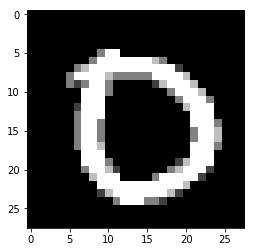

In [198]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))